In [36]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from IPython.display import Image
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [38]:
# Mobilenet expects 224 * 224 image
def prepare_image(file):
    img_path = './Images/dataset/with_mask/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

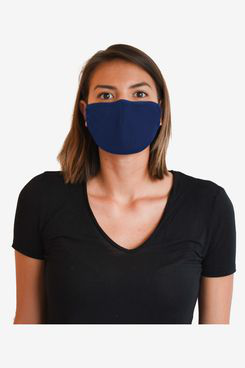

In [39]:
Image(filename='./Images/dataset/with_mask/image_0.png', width=300, height=200)

In [40]:
preprocessed_image = prepare_image('image_0.png')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n04355933', 'sunglass', 0.54441905),
  ('n03595614', 'jersey', 0.1874066),
  ('n02916936', 'bulletproof_vest', 0.103162184),
  ('n04356056', 'sunglasses', 0.09020485),
  ('n02667093', 'abaya', 0.015122795)]]

In [64]:
os.chdir('/Users/prashant/Downloads/FaceMaskDetector/Images/sign_lang')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
        
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [67]:
# os.chdir('Images')
train_path = 'Images/sign_lang/train'
valid_path = 'Images/sign_lang/valid'
test_path = 'Images/sign_lang/test'

# Changes pixel size range from 0 - 255 to -1 to 1
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [68]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [69]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [72]:
# Appending the layers to 6 from the last to the dense layer
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)

In [73]:
model = Model(inputs=mobile.input, outputs=output)

In [80]:
# Freezing some layers
for layer in model.layers[:-23]:
    layer.trainable = False

In [81]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [82]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
172/172 - 85s - loss: 0.6122 - accuracy: 0.8335 - val_loss: 0.2495 - val_accuracy: 0.9433
Epoch 2/10
172/172 - 80s - loss: 0.1122 - accuracy: 0.9778 - val_loss: 0.1323 - val_accuracy: 0.9633
Epoch 3/10
172/172 - 69s - loss: 0.0680 - accuracy: 0.9901 - val_loss: 0.0637 - val_accuracy: 0.9833
Epoch 4/10
172/172 - 70s - loss: 0.0391 - accuracy: 0.9977 - val_loss: 0.0479 - val_accuracy: 0.9867
Epoch 5/10
172/172 - 70s - loss: 0.0233 - accuracy: 0.9988 - val_loss: 0.0386 - val_accuracy: 0.9867
Epoch 6/10
172/172 - 69s - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9833
Epoch 7/10
172/172 - 69s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9900
Epoch 8/10
172/172 - 68s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0293 - val_accuracy: 0.9967
Epoch 9/10
172/172 - 76s - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9933
Epoch 10/10
172/172 - 76s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0208 - val_accura

In [84]:
test_labels = test_batches.classes

In [85]:
predictions = model.predict(x=test_batches, verbose=0)

In [86]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [87]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [90]:
# Extracted from Scikit learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


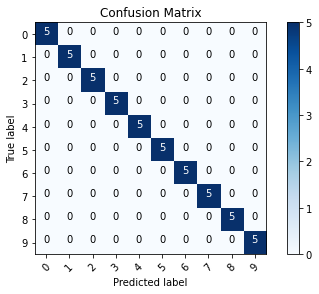

In [91]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')